In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(14)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y 

In [4]:
total_bandwidth = 100e6 # [Hz]
tx_power = 1 # [W]

environment_constant = 1e-4
pathloss_constant = 4

ref_distance = 1 # [m]

In [5]:
def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions

In [6]:
def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel() + y_pos.ravel()*1j)).reshape((num_ap, 1))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

In [49]:
def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.absolute(ue_pos[ue] - ap_pos[ap]) 
            
            if dis[0] >= ref_distance:
                dis_matrix[ue, ap] = dis[0]
            
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [8]:
def shadowing(std, num_ue, num_ap):

    return np.random.lognormal(sigma = std, size = (num_ue, num_ap))

In [9]:
def rayleigh(std, num_ue, num_ap, num_ch):

    return np.sqrt((std*np.random.randn(num_ch, num_ue, num_ap))**2 + (std*np.random.randn(num_ch, num_ue, num_ap))**2) 

In [76]:
def channel(distance, shadowing, rayleigh):

    channel_mat = shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh**2

    if rayleigh.shape[0] > 1:
        
        for row in range(rayleigh.shape[1]):
    
            channel_mat[np.random.randint(0, rayleigh.shape[0]), row, :] = np.zeros(rayleigh.shape[2])

    print(lin2db(channel_mat))
        
    for row in range(rayleigh.shape[1]):

        max_channel = np.max(channel_mat[:, row, :])
        
        for col in range(rayleigh.shape[2]):

            if channel_mat[:, row, col] != max_channel:

                channel_mat[:, row, col] = 0

    return channel_mat

In [11]:
def sinr(power_vector, channel, noise_p):
    
    sinr_matrix = np.zeros(channel.shape)
    sinr_vector = np.zeros(channel.shape[1])

    
    for ch in range(channel.shape[0]):

        for col in range(channel.shape[2]):
        
            channel_sum = 0
            
            for row in range(channel.shape[1]):

                channel_sum += np.abs(channel[ch, row, col]) * power_vector[row][0]
            
            for row in range(channel.shape[1]):
    
                interest_channel = power_vector[row][0] * np.abs(channel[ch, row, col])
                
                sinr_matrix[ch, row, col] = interest_channel / ((channel_sum - interest_channel) + noise_p)

    
    for row in range(channel.shape[1]):

        sinr_vector[row] = sinr_matrix[:, row, :].max()

    return lin2db(sinr_vector)

In [12]:
def snr(power_vector, channel, noise_p):

    snr_matrix = np.zeros(channel.shape)
    snr_vector = np.zeros(channel.shape[1])

    snr_matrix = (power_vector.reshape((snr_matrix.shape[0], 1)) * channel) / noise_p

    for row in range(snr_matrix.shape[0]):

        snr_vector[row] = snr_matrix[:, row, :].max()

    return lin2db(snr_vector)

In [13]:
def updown_dpc(channel, pmax, pmin, step, sinr_target, total_time, power_noise):

    power_vector = pmax * np.ones((1, channel.shape[1])).T 
    
    power_sum = np.zeros(total_time)

    power_evolution = np.zeros((channel.shape[1], total_time))
    
    time = 0

    for t in range(total_time):

        power_sum[t] = sum(power_vector.reshape((1, channel.shape[1]))[0])

        power_evolution[:, t] = power_vector.reshape(channel.shape[1])

        sinr_vector = sinr(dbm2lin(power_vector), channel, power_noise).reshape((1, channel.shape[1])).T

        power_vector = power_vector + step * np.sign(sinr_target - sinr_vector)
        
        for p in range(power_vector.shape[0]):

            if power_vector[p] > pmax:

                power_vector[p] = pmax

            elif power_vector[p] < pmin:

                power_vector[p] = pmin

        time += 1
            

    return power_vector, power_sum, power_evolution

In [14]:
def esnp_maxmin(channel, pmax, pmin, step, delta, epsilon, total_time, power_noise):

    num_ue = channel.shape[1]
    
    # Set of available transmit powers [dBm] for UEs to choose from
    
    available_tpower = np.array([pmin + step * m for m in range(int((pmax - pmin) / step + 1))])

    
    # Define power vector, sinr vector and objective function

    power_vec = pmax * np.ones((num_ue, 1))
    sinr_vec = 0
    maxmin_func = 0

    
    # Start iterations

    for t in range(total_time):

        sinr_vec = sinr(dbm2lin(power_vec), channel, power_noise)
                
        # Evaluate maxmin function

        if np.min(sinr_vec) > maxmin_func:

            maxmin_func = np.min(sinr_vec)

            # Set power vector based to delta and epsilon
            
            rand_value = np.random.rand()

            if rand_value < epsilon:

                for value in range(power_vec.shape[0]):

                    # Choose power randomly from the available power values
                    
                    power_vec[value] = available_tpower[np.random.randint(available_tpower.shape[0])]
            
            else:

                # Set power based on delta

                power_vec = power_vec + delta * (np.zeros((num_ue, 1))*rand_value - 0.5)


        # Keep the power values between power max and power min
            
        for value in range(power_vec.shape[0]):

            if power_vec[value] > pmax:

                power_vec[value] = pmax

            elif power_vec[value] < pmin:

                power_vec[value] = pmin

            else:

                pass

    return power_vec

In [15]:
def esnp_sumrate(channel, pmax, pmin, step, delta, epsilon, total_time, power_noise, bandwidth, num_ch):

    num_ue = channel.shape[1]
    
    # Set of available transmit powers [dBm] for UEs to choose from
    
    available_tpower = np.array([pmin + step * m for m in range(int((pmax - pmin) / step + 1))])

    
    # Define power vector, sinr vector and objective function

    power_vec = pmax * np.ones((num_ue, 1))
    sinr_vec = 0
    sumrate_func = -20

    
    # Start iterations

    for t in range(total_time):

        sinr_vec = sinr(dbm2lin(power_vec), channel, power_noise)
        capacity_sum = sum(capacity(bandwidth, num_ch, sinr_vec))
                
        # Evaluate sumrate function

        if capacity_sum > sumrate_func:

            sumrate_func = capacity_sum

            # Set power vector based to delta and epsilon
            
            rand_value = np.random.rand()

            if rand_value < epsilon:

                for value in range(power_vec.shape[0]):

                    # Choose power randomly from the available power values
                    
                    power_vec[value] = available_tpower[np.random.randint(available_tpower.shape[0])]
            
            else:

                # Set power based on delta

                power_vec = power_vec + delta * (np.zeros((num_ue, 1))*rand_value - 0.5)


        # Keep the power values between power max and power min
            
        for value in range(power_vec.shape[0]):

            if power_vec[value] > pmax:

                power_vec[value] = pmax

            elif power_vec[value] < pmin:

                power_vec[value] = pmin

            else:

                pass

    return power_vec

In [16]:
def capacity(total_bandwidth, num_ch, sinr):
    
    return ((total_bandwidth / num_ch) * np.log2(1 + db2lin(sinr))) / 1e6

In [17]:
def power_noise(total_bandwidth, num_ch):
    
    return (total_bandwidth/num_ch) * 1e-20

In [18]:
num_ue = 4
num_ap = 4
num_ch = 1

cov_side_noise = 1000 # [m]
cov_side_interference = 100 # [m]
seeds = 100

sh_std = 2
mp_std = 1 / np.sqrt(2) 

In [19]:
p_max = 30 # [dBm]
p_min = 0 # [dBm]

total_time = 100

step = 1 # [dBm]
sinr_target = 1 # [dB]

In [77]:
noise_p = power_noise(total_bandwidth, num_ch)

total_sinr_npc = np.zeros((num_ue, seeds))
total_sinr_ud = np.zeros((num_ue, seeds))
total_sinr_esnp = np.zeros((num_ue, seeds))

total_capacity_npc = np.zeros((num_ue, seeds))
total_capacity_ud = np.zeros((num_ue, seeds))
total_capacity_esnp = np.zeros((num_ue, seeds))

each_power_evolution_ud = np.zeros((num_ue, total_time, seeds))
total_power_evolution_ud = np.zeros((total_time, seeds))

for seed in range(seeds):

    # Study case values
    
    ue_pos = np.array([[225.38 + 203.33j], 
                       [566.79 + 321.88j], 
                       [765.51 + 146.88j], 
                       [265.95 + 702.39j]])
    
    ap_pos = ap_positions(num_ap, cov_side_noise)
    distances = distance(ue_pos, ap_pos)
    
    shadowing_matrix = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1], 
                                 [3.2318, 1.5770, 2.6449e-1, 5.6379], 
                                 [6.1470e-3, 1.1424, 2.6826e-1, 4.5709], 
                                 [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
     
    rayleigh_matrix = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                                [0.498887, 0.104890, 0.647280, 0.940906], 
                                [0.382966, 0.682700, 1.891256, 0.327100], 
                                [0.065737, 0.649500, 1.981107, 1.259538]]).reshape((num_ch, num_ue, num_ap))

    
    # Channel coefficients matrix
    
    random_matrix = channel(distances, shadowing_matrix, rayleigh_matrix)

    
    # No power control (or max power)
    
    npc_power = p_max * np.ones(num_ue).reshape((1, random_matrix.shape[1])).T

    
    # Up-down Distributed Power Control (UD-DPC)
    
    updown = updown_dpc(random_matrix, p_max, p_min, step, sinr_target, total_time, noise_p)
    
    ud_power = updown[0].reshape((1, random_matrix.shape[1])).T
    total_power_evolution_ud[:, seed] = updown[1]
    each_power_evolution_ud[:, :, seed] = updown[2]


    # Exhaustive Search with Neighborhood preference (ESNP)
    
    esnp_power = esnp_sumrate(random_matrix, p_max, p_min, step, 0.5, 10, total_time, noise_p, total_bandwidth, num_ch)
    
    
    # SINR 
    
    system_sinr_npc = sinr(dbm2lin(npc_power), random_matrix, noise_p)
    system_sinr_ud = sinr(dbm2lin(ud_power), random_matrix, noise_p)
    system_sinr_esnp = sinr(dbm2lin(esnp_power), random_matrix, noise_p)
    
    total_sinr_npc[:, seed] = system_sinr_npc
    total_sinr_ud[:, seed] = system_sinr_ud
    total_sinr_esnp[:, seed] = system_sinr_esnp

    
    # Capacity
    
    total_capacity_npc[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_npc)
    total_capacity_ud[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_ud)
    total_capacity_esnp[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_esnp)
    
    
    clear_output(wait=True)

    # print(ue_pos, '\n')
    # print(ap_pos, '\n')
    # print(distances, '\n')
    # print(lin2db(random_matrix))

[[[-119.68678033 -144.04632421 -168.82310618 -159.5329    ]
  [-141.41242433 -149.36854301 -158.609494   -139.74119577]
  [-179.28043071 -123.46524181 -156.15940837 -154.32826344]
  [-178.57660319 -159.90469915 -103.15884964 -143.23693545]]]


In [78]:
noise_p = power_noise(total_bandwidth, num_ch)

total_sinr_npc = np.zeros((num_ue, seeds))
total_sinr_ud = np.zeros((num_ue, seeds))
total_sinr_esnp = np.zeros((num_ue, seeds))

total_capacity_npc = np.zeros((num_ue, seeds))
total_capacity_ud = np.zeros((num_ue, seeds))
total_capacity_esnp = np.zeros((num_ue, seeds))

each_power_evolution_ud = np.zeros((num_ue, total_time, seeds))
total_power_evolution_ud = np.zeros((total_time, seeds))

for seed in range(seeds):

    # Study case values
    
    ue_pos = np.array([[22.538 + 20.333j], 
                       [56.679 + 32.188j], 
                       [76.551 + 14.688j], 
                       [26.595 + 70.239j]])
    
    ap_pos = ap_positions(num_ap, cov_side_interference)
    distances = distance(ue_pos, ap_pos)
    
    shadowing_matrix = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1], 
                                 [3.2318, 1.5770, 2.6449e-1, 5.6379], 
                                 [6.1470e-3, 1.1424, 2.6826e-1, 4.5709], 
                                 [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
     
    rayleigh_matrix = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                                [0.498887, 0.104890, 0.647280, 0.940906], 
                                [0.382966, 0.682700, 1.891256, 0.327100], 
                                [0.065737, 0.649500, 1.981107, 1.259538]]).reshape((num_ch, num_ue, num_ap))

    
    # Channel coefficients matrix
    
    random_matrix = channel(distances, shadowing_matrix, rayleigh_matrix)

    
    # No power control (or max power)
    
    npc_power = p_max * np.ones(num_ue).reshape((1, random_matrix.shape[1])).T

    
    # Up-down Distributed Power Control (UD-DPC)
    
    updown = updown_dpc(random_matrix, p_max, p_min, step, sinr_target, total_time, noise_p)
    
    ud_power = updown[0].reshape((1, random_matrix.shape[1])).T
    total_power_evolution_ud[:, seed] = updown[1]
    each_power_evolution_ud[:, :, seed] = updown[2]


    # Exhaustive Search with Neighborhood preference (ESNP)
    
    esnp_power = esnp_sumrate(random_matrix, p_max, p_min, step, 0.5, 10, total_time, noise_p, total_bandwidth, num_ch)
    
    
    # SINR 
    
    system_sinr_npc = sinr(dbm2lin(npc_power), random_matrix, noise_p)
    system_sinr_ud = sinr(dbm2lin(ud_power), random_matrix, noise_p)
    system_sinr_esnp = sinr(dbm2lin(esnp_power), random_matrix, noise_p)
    
    total_sinr_npc[:, seed] = system_sinr_npc
    total_sinr_ud[:, seed] = system_sinr_ud
    total_sinr_esnp[:, seed] = system_sinr_esnp

    
    # Capacity
    
    total_capacity_npc[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_npc)
    total_capacity_ud[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_ud)
    total_capacity_esnp[:, seed] = capacity(total_bandwidth, num_ch, system_sinr_esnp)
        
    clear_output(wait=True)   

    # print(ue_pos, '\n')
    # print(ap_pos, '\n')
    # print(distances, '\n')
    # print(lin2db(random_matrix))

[[[ -79.68678033 -104.04632421 -128.82310618 -119.5329    ]
  [-101.41242433 -109.36854301 -118.609494    -99.74119577]
  [-139.28043071  -83.46524181 -116.15940837 -114.32826344]
  [-138.57660319 -119.90469915  -63.15884964 -103.23693545]]]


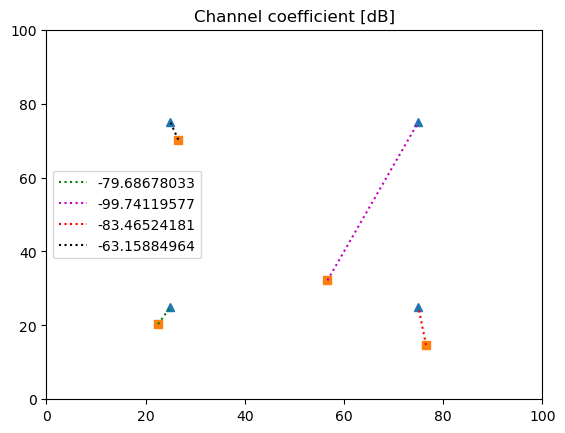

In [80]:
ap_pos = ap_positions(num_ap, cov_side_interference)

ue_pos = np.array([[22.538 + 20.333j], 
                   [56.679 + 32.188j], 
                   [76.551 + 14.688j], 
                   [26.595 + 70.239j]])

plt.xlim(0, cov_side_interference)
plt.ylim(0, cov_side_interference)

plt.plot(np.real(ap_pos), np.imag(ap_pos), '^')
plt.plot(np.real(ue_pos), np.imag(ue_pos), 's')

plt.plot((np.real(ue_pos[0]), np.real(ap_pos[0])), (np.imag(ue_pos[0]), np.imag(ap_pos[0])), 'g:', label='-79.68678033')
plt.plot((np.real(ue_pos[1]), np.real(ap_pos[3])), (np.imag(ue_pos[1]), np.imag(ap_pos[3])), 'm:', label='-99.74119577')
plt.plot((np.real(ue_pos[2]), np.real(ap_pos[1])), (np.imag(ue_pos[2]), np.imag(ap_pos[1])), 'r:', label='-83.46524181')
plt.plot((np.real(ue_pos[3]), np.real(ap_pos[2])), (np.imag(ue_pos[3]), np.imag(ap_pos[2])), 'k:', label='-63.15884964')

plt.title('Channel coefficient [dB]')
plt.legend()

plt.savefig('interference-scenario.jpeg')

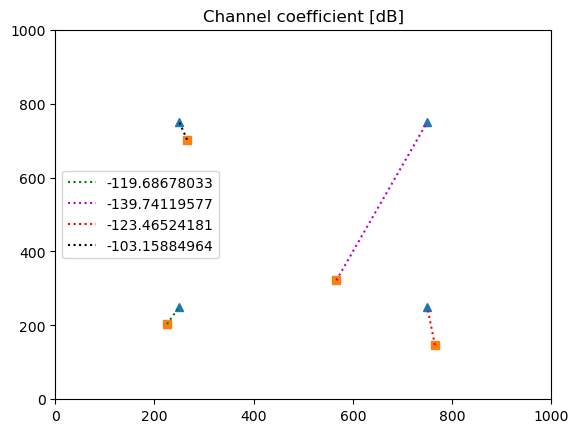

In [79]:
ap_pos = ap_positions(num_ap, cov_side_noise)

ue_pos = np.array([[225.38 + 203.33j], 
                   [566.79 + 321.88j], 
                   [765.51 + 146.88j], 
                   [265.95 + 702.39j]])

plt.xlim(0, cov_side_noise)
plt.ylim(0, cov_side_noise)

plt.plot(np.real(ap_pos), np.imag(ap_pos), '^')
plt.plot(np.real(ue_pos), np.imag(ue_pos), 's')

plt.plot((np.real(ue_pos[0]), np.real(ap_pos[0])), (np.imag(ue_pos[0]), np.imag(ap_pos[0])), 'g:', label='-119.68678033')
plt.plot((np.real(ue_pos[1]), np.real(ap_pos[3])), (np.imag(ue_pos[1]), np.imag(ap_pos[3])), 'm:', label='-139.74119577')
plt.plot((np.real(ue_pos[2]), np.real(ap_pos[1])), (np.imag(ue_pos[2]), np.imag(ap_pos[1])), 'r:', label='-123.46524181')
plt.plot((np.real(ue_pos[3]), np.real(ap_pos[2])), (np.imag(ue_pos[3]), np.imag(ap_pos[2])), 'k:', label='-103.15884964')

plt.title('Channel coefficient [dB]')
plt.legend()

plt.savefig('noise-scenario.jpeg')